# Fitting By Minimizing

Earlier in this course, we briefly examined the least squares algorithm for fitting a straight line to data. The idea behind least squares is that the line that best fits the data will minimize the distance to the data being fit. This concept of minimizing distance to datapoints can be generalized to fitting functions with N free parameters (as opposed to just slope and intercept).

## Cost Function

To quantify the distance to data points in a fitting problem, we define a *cost function*. Often the cost function is very similar to least squares, with this generalized version often referred to as $\chi^2$. A simple $\chi^2$ metric can be defined as

$$ \chi^2 = \sum_n \Bigg(\frac{(y_n - f(x_n))}{y_n}\Bigg)^2 $$

where $f(x)$ is the model function we're fitting to the data. In general $x$ could be vector. This simple function is often expanded to account for uncertainties, e.g., by adding a $y_{err}$ term in the denominator, and one could imagine other ways to expand the function (stay tuned for next lecture!)

The function that best fits the data will have a minimum $\chi^2$ value, so to fit a function to data, we can use minimization algorithm combined with a $\chi^2$ cost function.

## Write a minimization fitting function

To write your own minimization fitting algorithm, you'll first need to define a cost function. For now I recommend the simple $\chi^2$ algorithm defined above. Coding this may be a little tricky: your cost function needs to be callable by your minimization algorithm, but itself must call the function you're fitting. You *could* write a single use cost function that is hard coded with the model function you're fitting, and that's a completely acceptable solution. Though as we've discussed in the past, it is always nice to write re-usable code. If you can, you should try to write code that accepts the model function to be fit and still provides a callable cost function for your minization algorithm. We've covered *functals* previously in this course which may provide a solution. Another option is *lambda functions* (google it).

Below, I've created a function def called `chisquare` that accepts the data we're fitting to, `xdat` and `ydat`, along with the model function to be fit, `func`. I've also provided some plotting code to visualize the "surface" of "goodness-of-fit" as defined by the $\chi^2$ metric. As you see, the result of my `chisquare` function is another callable function which can be used both to construct the "surface" and minimize my function.

Once you have your callable cost function, use a minimization algorithm to find the best fit parameters. I've copied over the nelder_mead algorithm for convenience. Forgive the simple model function, it's just for illustrative purposes. I've provided slightly more interesting examples in Homework 5, but the sky is the limit on fitting; you could fit functions of 4, 5, 10, or more parameters (though practically you will hit computational limits eventually).

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):

    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

In [17]:

def chisquare(xdat, ydat, func):
    def returnfunction(input):
        X2sum = 0
        for i in range(len(ydat)):
            X2sum += ((ydat[i] - func(xdat[i], *input))/ydat[i])**2
        return X2sum
    return returnfunction

def line(x, m, b):
    return m*x + b

[2.00002767 1.00002765]


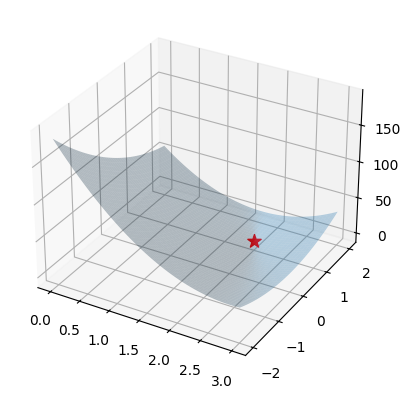

In [18]:
x = np.arange(0, 10, 0.1)
y = line(x, 2, 1)

m_plot = np.linspace(0, 3, 100)
b_plot = np.linspace(-2, 2, 100)
x_plot, y_plot = np.meshgrid(m_plot, b_plot)
z = np.zeros_like(x_plot)

chi = chisquare(x, y, line)

for i in range(len(x_plot)):
    for j in range(len(x_plot)):
        z[i,j] = chi((x_plot[i,j],y_plot[i,j]))

best, score = nelder_mead(chi, np.array([1.9, 0.1], float))
print(best)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

surf = ax.plot_surface(x_plot, y_plot, z, alpha=0.3)

ax.scatter(best[0], best[1], chi((best[0], best[1])), marker="*", s=100, color="r")